# Revenue Prediction with Cohort Analysis with BART

This notebook is inspired and largely based on the [article](https://juanitorduz.github.io/revenue_retention/) by Dr Juan Orduz. We work with an anonymized dataset of online transactions from the period 2021-2024 and forecast future revenue. 

## Notebook Setup

In [1]:
import deep_ocean_bart
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import graphviz
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import xarray as xr
import seaborn as sns
import pandas as pd

import pymc as pm 
import pymc_bart as pmb
import pytensor
import pytensor.tensor as pt

from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule
from scipy.special import logit
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.metrics import (
    mean_absolute_percentage_error
)
from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning, module="pymc")

## Data loading & Preprocessing

In our dataset we observe order level data. For each order entry, we have an associated date, order timestamp, customer ID, and revenue.

In [2]:
transactions = deep_ocean_bart.load_transactions('./transactions.csv')
transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00
...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00


We get a feel of our dataset by taking some summary statistics

In [3]:
print(f"Dataset contains {transactions.shape[0]} entries") 
print(f"Number of unique order id: {len(transactions['ORDER_KEY'].unique())}")
print(f"Number of unique customers: {len(transactions['CUSTOMER_KEY'].unique())}")
print(f"Starting date: {transactions['DATE_KEY'].min()}")
print(f"Starting date: {transactions['DATE_KEY'].max()}")

Dataset contains 630398 entries
Number of unique order id: 630398
Number of unique customers: 206243
Starting date: 2021-01-01 00:00:00
Starting date: 2024-10-18 00:00:00


The majority of orders are between $0 to $500. We plot a histogram of order value in log scale to visualize distribution of individual order level.

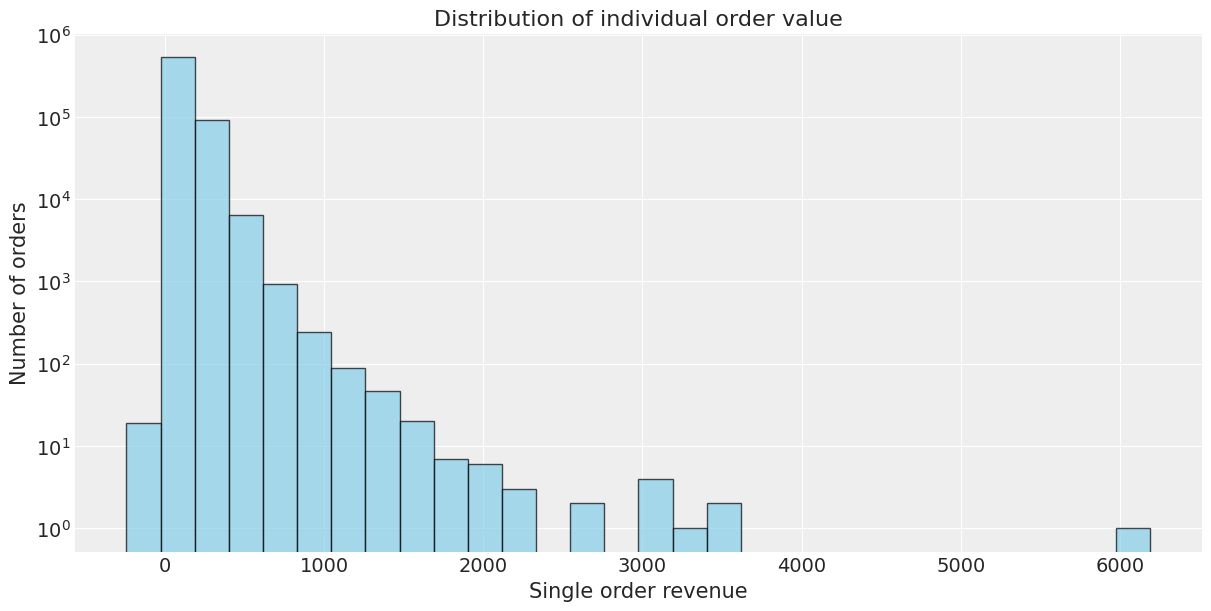

In [4]:
plt.figure(figsize=(12, 6))
plt.hist(
    transactions['FULL_REVENUE'],
    log=True,
    color='skyblue',
    edgecolor='black',
    alpha = .7,
    bins = 30,
)
plt.title("Distribution of individual order value")
plt.xlabel("Single order revenue")
plt.ylabel("Number of orders")
plt.show()

The majority of customers are "once and gone"

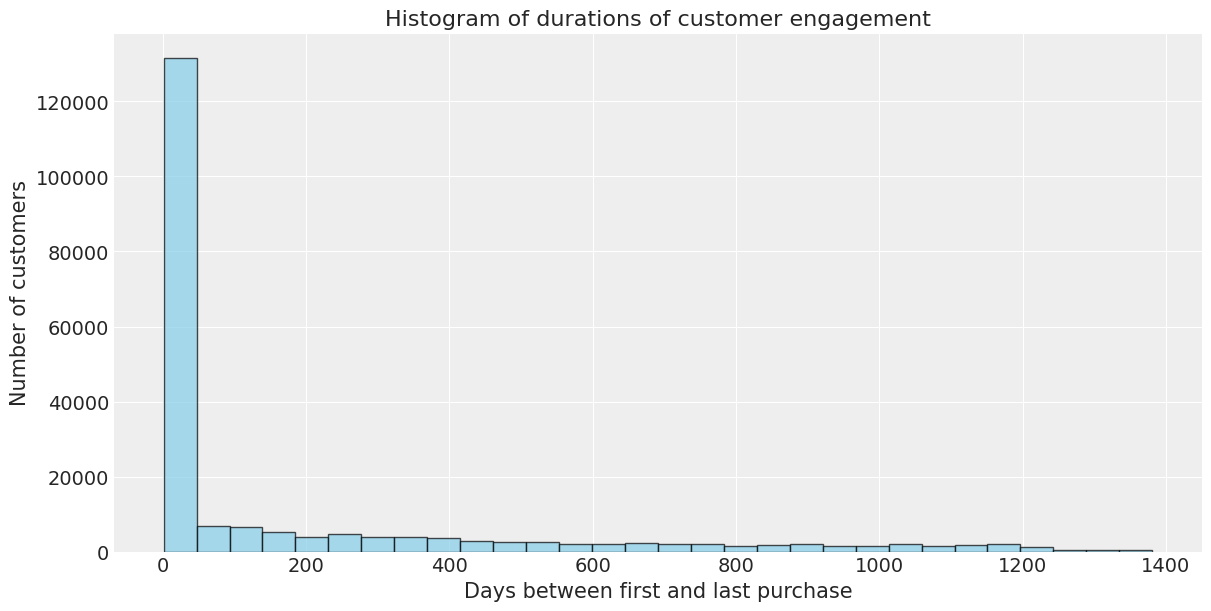

Number of customers who spent only once: 115913( 56.20 % of dataset)


In [5]:
customer_engagement = transactions.groupby(
    by='CUSTOMER_KEY',
)['DATE_KEY'].apply(lambda x: x.max() - x.min())
customer_engagement

t = customer_engagement / pd.to_timedelta('1d')
t += 1
plt.figure(figsize=(12, 6))
plt.hist(
    t,
    color='skyblue',
    edgecolor='black',
    alpha = .7,
    bins = 30,
)
plt.title("Histogram of durations of customer engagement")
plt.xlabel("Days between first and last purchase")
plt.ylabel("Number of customers")
plt.show()

print(f"""Number of customers who spent only once: {
    sum(t == 1)
}({sum(t == 1) * 100 / t.size: .2f} % of dataset)""")

We assign each order with a week, month, and cohort label.

Cohorts are assigned based on the month of first purchase.

In [8]:
transactions = deep_ocean_bart.preprocess_transactions(transactions)
transactions

,CUSTOMER_KEY,ORDER_KEY,DATE_KEY,ORDER_TIMESTAMP,FULL_REVENUE,WEEK,MONTH,COHORT
0,1002115858489.0,3754939678860,2021-07-12,2021-07-12 12:10:45,35.00,2021-07-12,2021-07-01,2021-07-01
1,1002260725817.0,3729385947276,2021-06-04,2021-06-04 12:04:36,148.00,2021-05-31,2021-06-01,2021-06-01
2,1002260725817.0,3743016845452,2021-06-23,2021-06-23 12:05:46,172.00,2021-06-21,2021-06-01,2021-06-01
3,1002260725817.0,3755584585868,2021-07-13,2021-07-13 07:49:00,247.00,2021-07-12,2021-07-01,2021-06-01
4,1002260725817.0,3764388561036,2021-07-26,2021-07-26 13:47:14,125.00,2021-07-26,2021-07-01,2021-06-01
...,...,...,...,...,...,...,...,...
633694,999645773881.0,4403813122188,2023-02-23,2023-02-23 10:13:03,150.00,2023-02-20,2023-02-01,2021-05-01
633695,999645773881.0,4426178396300,2023-03-16,2023-03-16 10:50:07,44.00,2023-03-13,2023-03-01,2021-05-01
633696,999645773881.0,4451106095244,2023-04-13,2023-04-13 09:33:48,112.00,2023-04-10,2023-04-01,2021-05-01
633697,999645773881.0,4485327487116,2023-05-23,2023-05-23 11:04:43,60.00,2023-05-22,2023-05-01,2021-05-01


We observe some seasonality effects in our dataset.

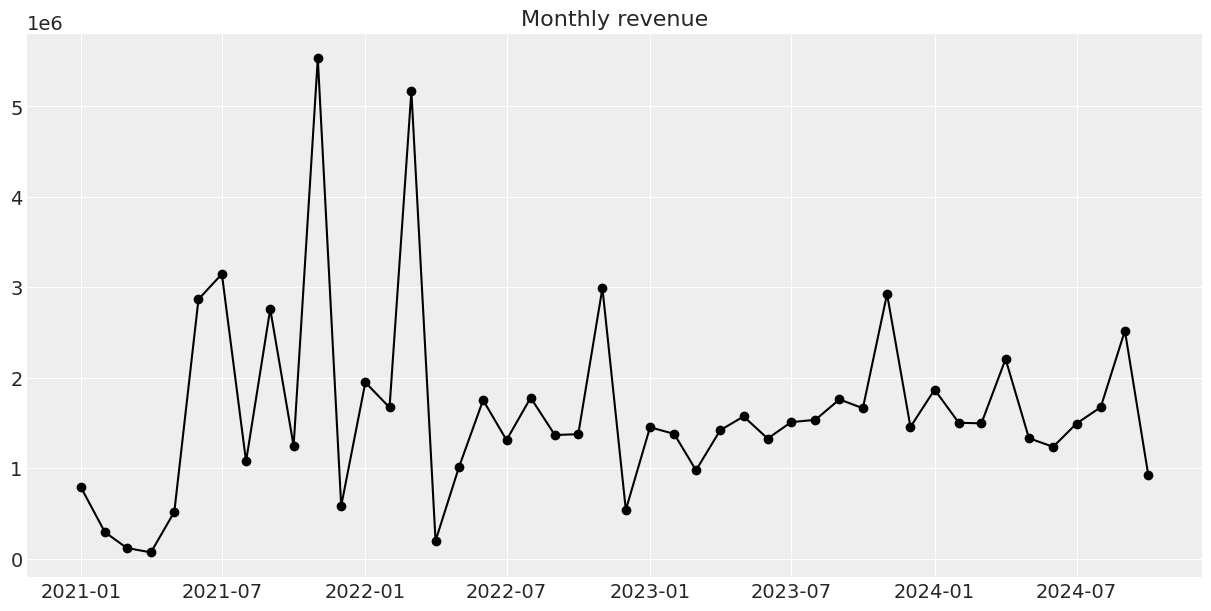

In [9]:
plt.figure(figsize=(12,6))
plt.plot(
    transactions.groupby(['MONTH'])['FULL_REVENUE'].sum(),
    color = "black",
    marker = 'o'
)
plt.title("Monthly revenue")
plt.show()

We pivot our transactions-view dataframe into a cohort-view dataframe. For each cohort and each period, we observe the number of active users and revenue.

In [10]:
cohort = deep_ocean_bart.preprocess_transactions_to_cohort(transactions)
cohort

,cohort,period,n_active_users,revenue,n_users,age,cohort_age,retention,revenue_per_user,revenue_per_active_user
0,2021-01-01,2021-01-01,4795.0,793272.36,4795.0,1386.0,0.0,1.000000,165.437406,165.437406
1,2021-01-01,2021-02-01,201.0,28250.62,4795.0,1386.0,31.0,0.041919,5.891683,140.550348
2,2021-01-01,2021-03-01,126.0,23775.12,4795.0,1386.0,59.0,0.026277,4.958315,188.691429
3,2021-01-01,2021-04-01,91.0,7701.63,4795.0,1386.0,90.0,0.018978,1.606179,84.633297
4,2021-01-01,2021-05-01,418.0,49701.21,4795.0,1386.0,120.0,0.087174,10.365216,118.902416
...,...,...,...,...,...,...,...,...,...,...
1628,2024-10-01,2025-06-01,NaN,NaN,1076.0,17.0,243.0,NaN,NaN,NaN
1629,2024-10-01,2025-07-01,NaN,NaN,1076.0,17.0,273.0,NaN,NaN,NaN
1630,2024-10-01,2025-08-01,NaN,NaN,1076.0,17.0,304.0,NaN,NaN,NaN
1631,2024-10-01,2025-09-01,NaN,NaN,1076.0,17.0,335.0,NaN,NaN,NaN


<Axes: xlabel='period', ylabel='cohort'>

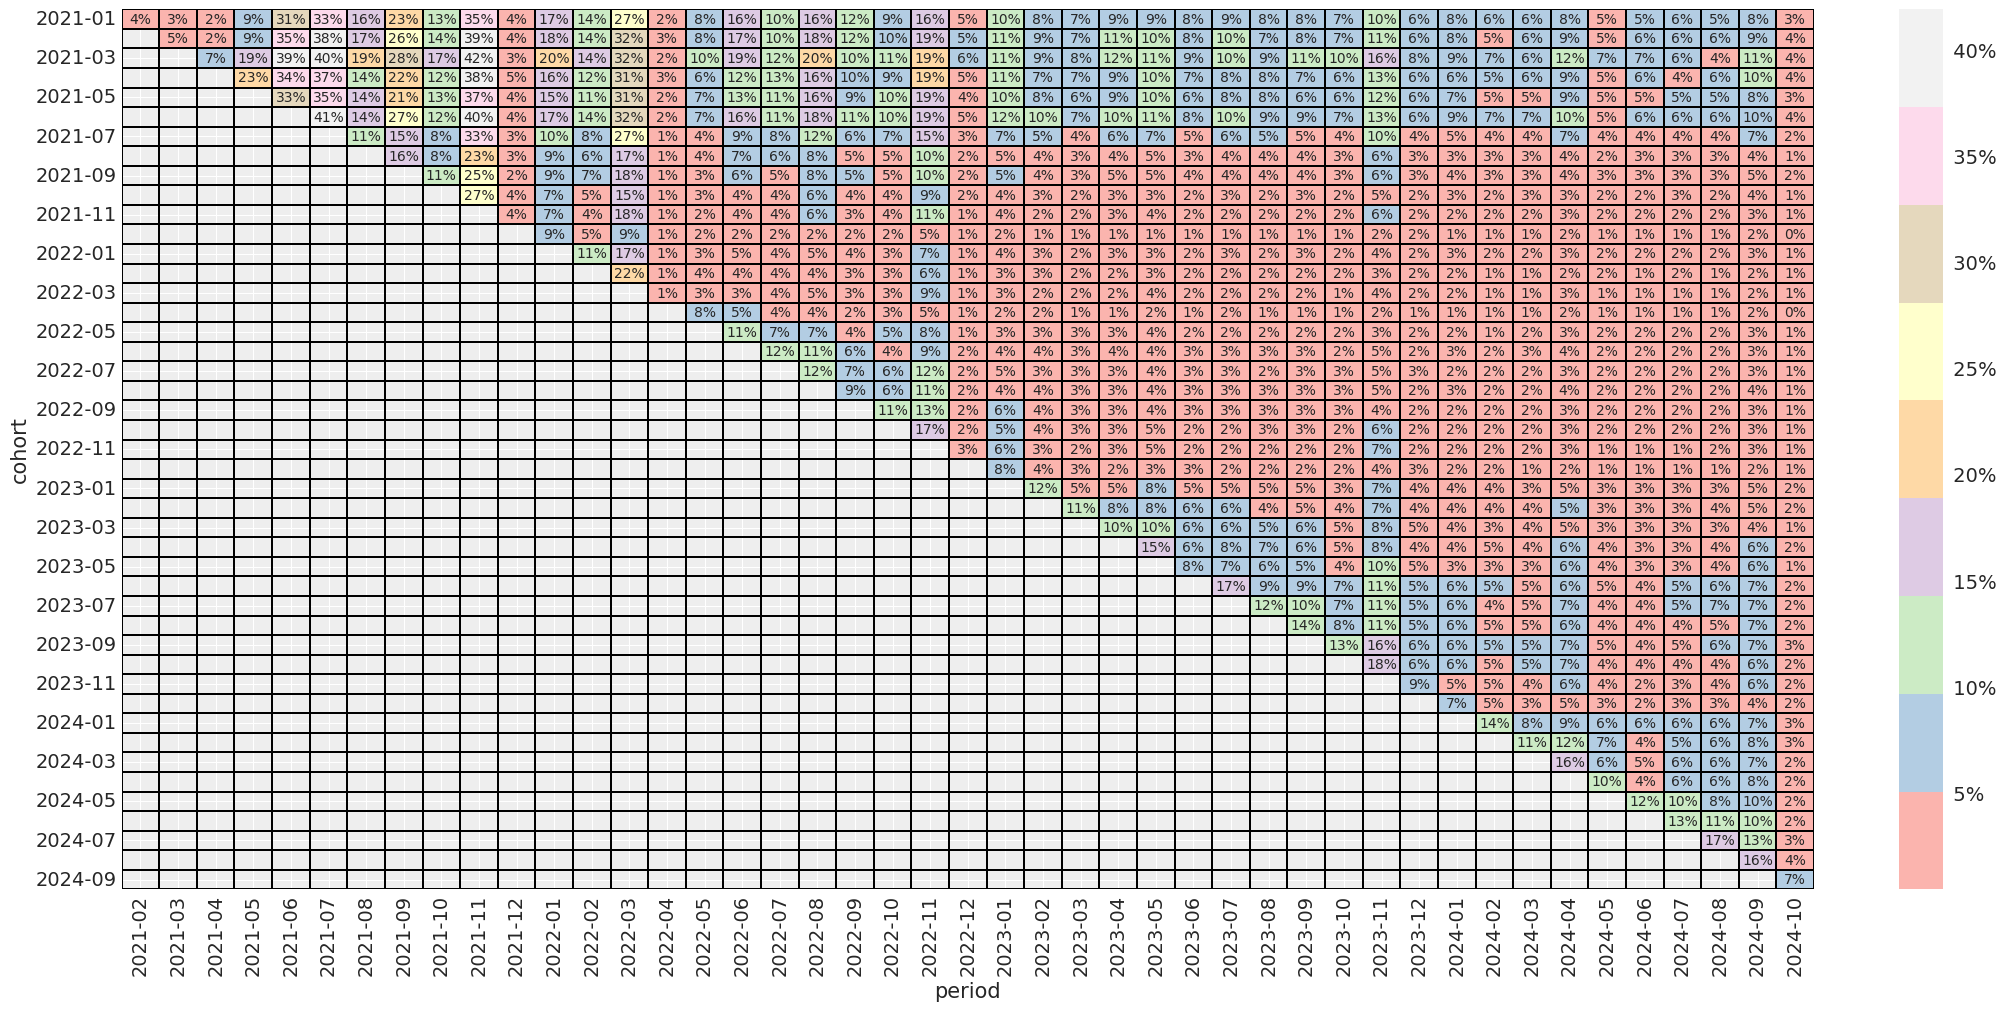

In [11]:
fig, ax = plt.subplots(figsize = (20, 10))
fmt = lambda x, _ : f"{x: 0.0%}"
max_cohort = cohort['cohort'].max().strftime("%Y-%m-%d")

cohort.assign(
    cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
    period=lambda df: df["period"].dt.strftime("%Y-%m"),
).query(
        "cohort_age != 0 & period < @max_cohort" 
).filter(
    ["cohort", "period", "retention"]
).pivot(
    index = "cohort",
    columns = "period",
    values = "retention"
).pipe(
    (sns.heatmap, "data"),
    cmap="Pastel1",
    linewidths=0.2,
    linecolor="black",
    annot=True,
    fmt="0.0%",
    cbar_kws={"format": mtick.FuncFormatter(fmt)},
    ax=ax,
)

## BART Modeling

We use data up to June 1st, 2023 as training. All subsequent data is used for testing.

The interface also allows us to limit training data or testing data to a specified time period before / after the cutoff date.

In [12]:
cutoff = datetime.datetime(2023, 6, 1)
train_df, test_df = deep_ocean_bart.custom_train_test_split(cutoff, cohort)

In [13]:
train_features = deep_ocean_bart.preprocess_train_test_data(train_df, mode = "train")
for key in train_features.keys():
    print(f"{key}: {type(train_features[key])}")

obs_idx: <class 'numpy.ndarray'>
n_users: <class 'numpy.ndarray'>
n_active_users: <class 'numpy.ndarray'>
retention: <class 'numpy.ndarray'>
revenue: <class 'numpy.ndarray'>
features: <class 'list'>
x: <class 'pandas.core.frame.DataFrame'>
period: <class 'numpy.ndarray'>
cohorts: <class 'numpy.ndarray'>
cohort_idx: <class 'numpy.ndarray'>
age_scaled: <class 'numpy.ndarray'>
cohort_age_scaled: <class 'numpy.ndarray'>
cohort_encoder: <class 'sklearn.preprocessing._label.LabelEncoder'>
age_scaler: <class 'sklearn.preprocessing._data.MaxAbsScaler'>
cohort_age_scaler: <class 'sklearn.preprocessing._data.MaxAbsScaler'>
period_idx: <class 'numpy.ndarray'>
retention_logit: <class 'numpy.ndarray'>
revenue_per_user: <class 'numpy.ndarray'>
data_red_df: <class 'pandas.core.frame.DataFrame'>


The test portion is what we hope to recover, up to one year from cutoff date.

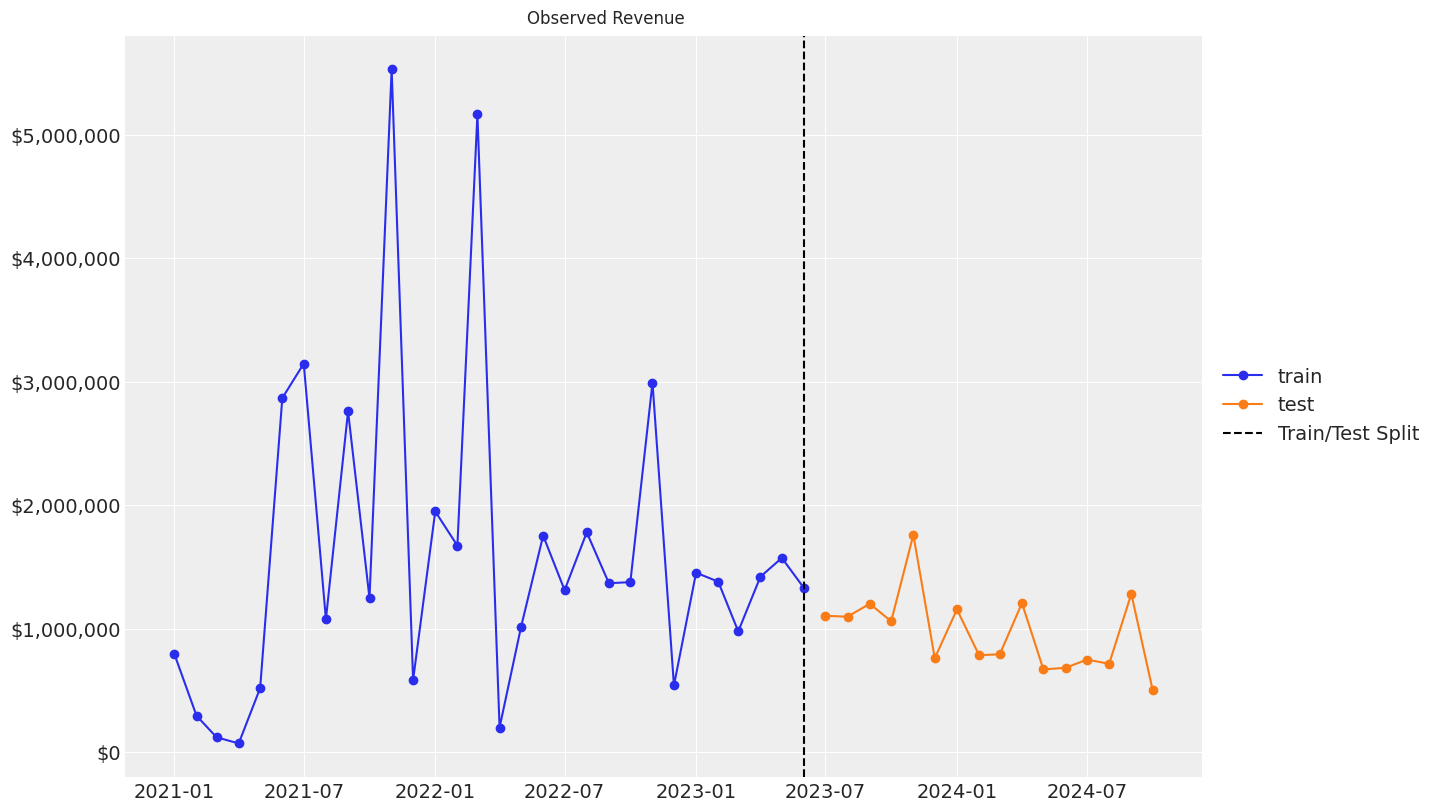

In [14]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(
    train_df.groupby(['period'])['revenue'].sum(),
    label = "train",
    color = 'C0',
    marker = 'o'
)
ax.plot(
    test_df[
        ~test_df['revenue'].isna()
    ].groupby(['period'])['revenue'].sum(),
    label = "test",
    color = 'C1',
    marker = 'o'
)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.axvline(x=cutoff, color='black', linestyle='--', label='Train/Test Split')
fig.suptitle("Observed Revenue")
fig.legend(loc = "center left", bbox_to_anchor = (1, .5))
plt.show()


We build a revenue model with BART to estimate the number of users and a Gamma component for revenue per transaction.

In [15]:
model = deep_ocean_bart.build_new_model(train_features, use_default_priors=True)
model

                           intercept ~ Normal(1, 1)
                        b_age_scaled ~ Normal(0, 1)
                 b_cohort_age_scaled ~ Normal(0, 1)
        b_age_cohort_age_interaction ~ Normal(0, 1)
                       b_seasonality ~ Normal(0, 1)
       b_seasonality_age_interaction ~ Normal(0, 1)
b_seasonality_cohort_age_interaction ~ Normal(0, 1)
                                  mu ~ BART(<shared>, <constant>, 50, 0.95, 2)
                                   p ~ Deterministic(f(mu))
                             lam_log ~ Deterministic(f(b_seasonality_cohort_age_interaction, b_seasonality_age_interaction, b_seasonality, intercept, b_age_cohort_age_interaction, b_cohort_age_scaled, b_age_scaled))
                                 lam ~ Deterministic(f(b_seasonality_cohort_age_interaction, b_seasonality_age_interaction, b_seasonality, intercept, b_age_cohort_age_interaction, b_cohort_age_scaled, b_age_scaled))
            n_active_users_estimated ~ Binomial(<shared>, f(mu))


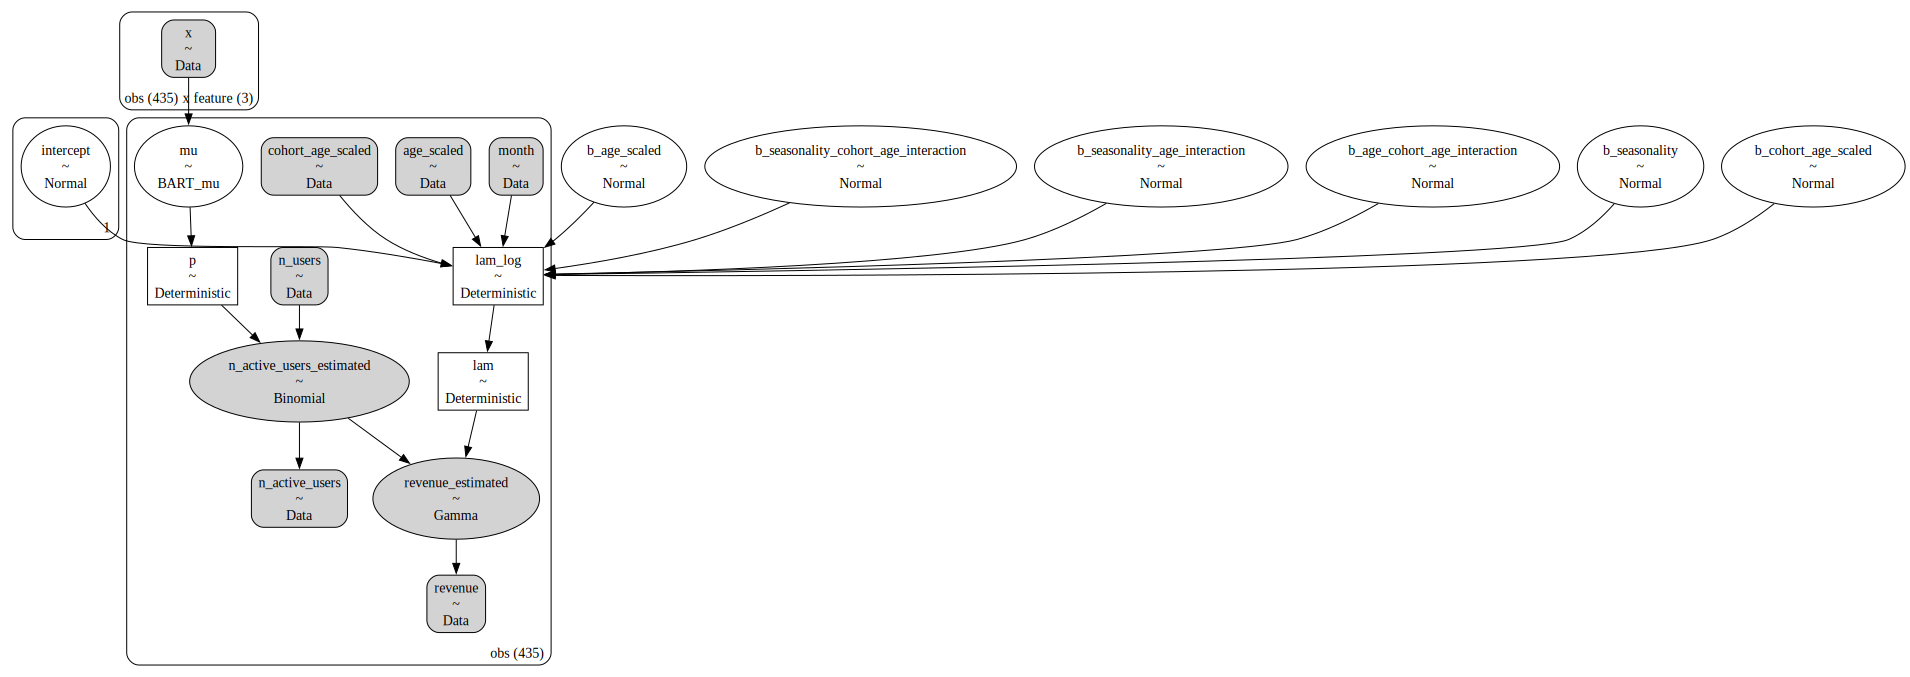

In [16]:
model.to_graphviz()

In [17]:
model, idata, pos_predictive = deep_ocean_bart.fit_model(model)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_seasonality, b_seasonality_age_interaction, b_seasonality_cohort_age_interaction]
>PGBART: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

Posterior predictive check:

[Text(0.5, 1.0, 'Posterior Predictive Check (Revenue)'),
 None,
 Text(0.5, 0, 'likelihood (revenue) - log scale'),
 (1, 1473133.0678904518)]

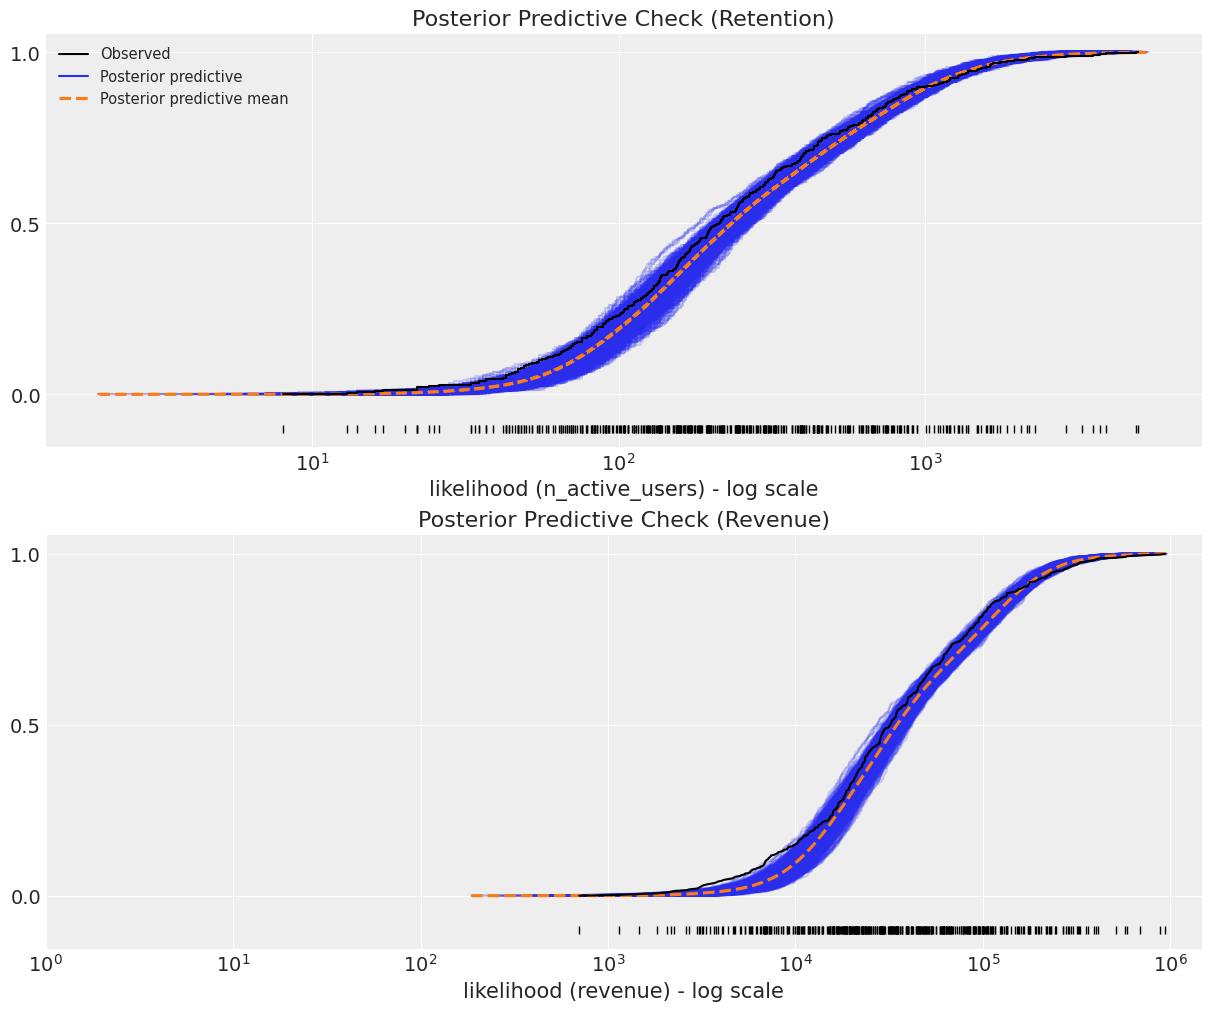

In [18]:
ax = az.plot_ppc(
    data=pos_predictive,
    kind="cumulative",
    observed_rug=True,
    grid=(2, 1),
    figsize=(12, 10),
    random_seed=42,
)
ax[0].set(
    title="Posterior Predictive Check (Retention)",
    xscale="log",
    xlabel="likelihood (n_active_users) - log scale",
)
ax[1].set(
    title="Posterior Predictive Check (Revenue)",
    xscale="log",
    xlabel="likelihood (revenue) - log scale",
    xlim=(1, None),
)

We verify that the model converges.

In [19]:
assert idata.sample_stats["diverging"].sum().item() == 0

We examine trace plots.

Text(0.5, 0.98, 'Model Trace')

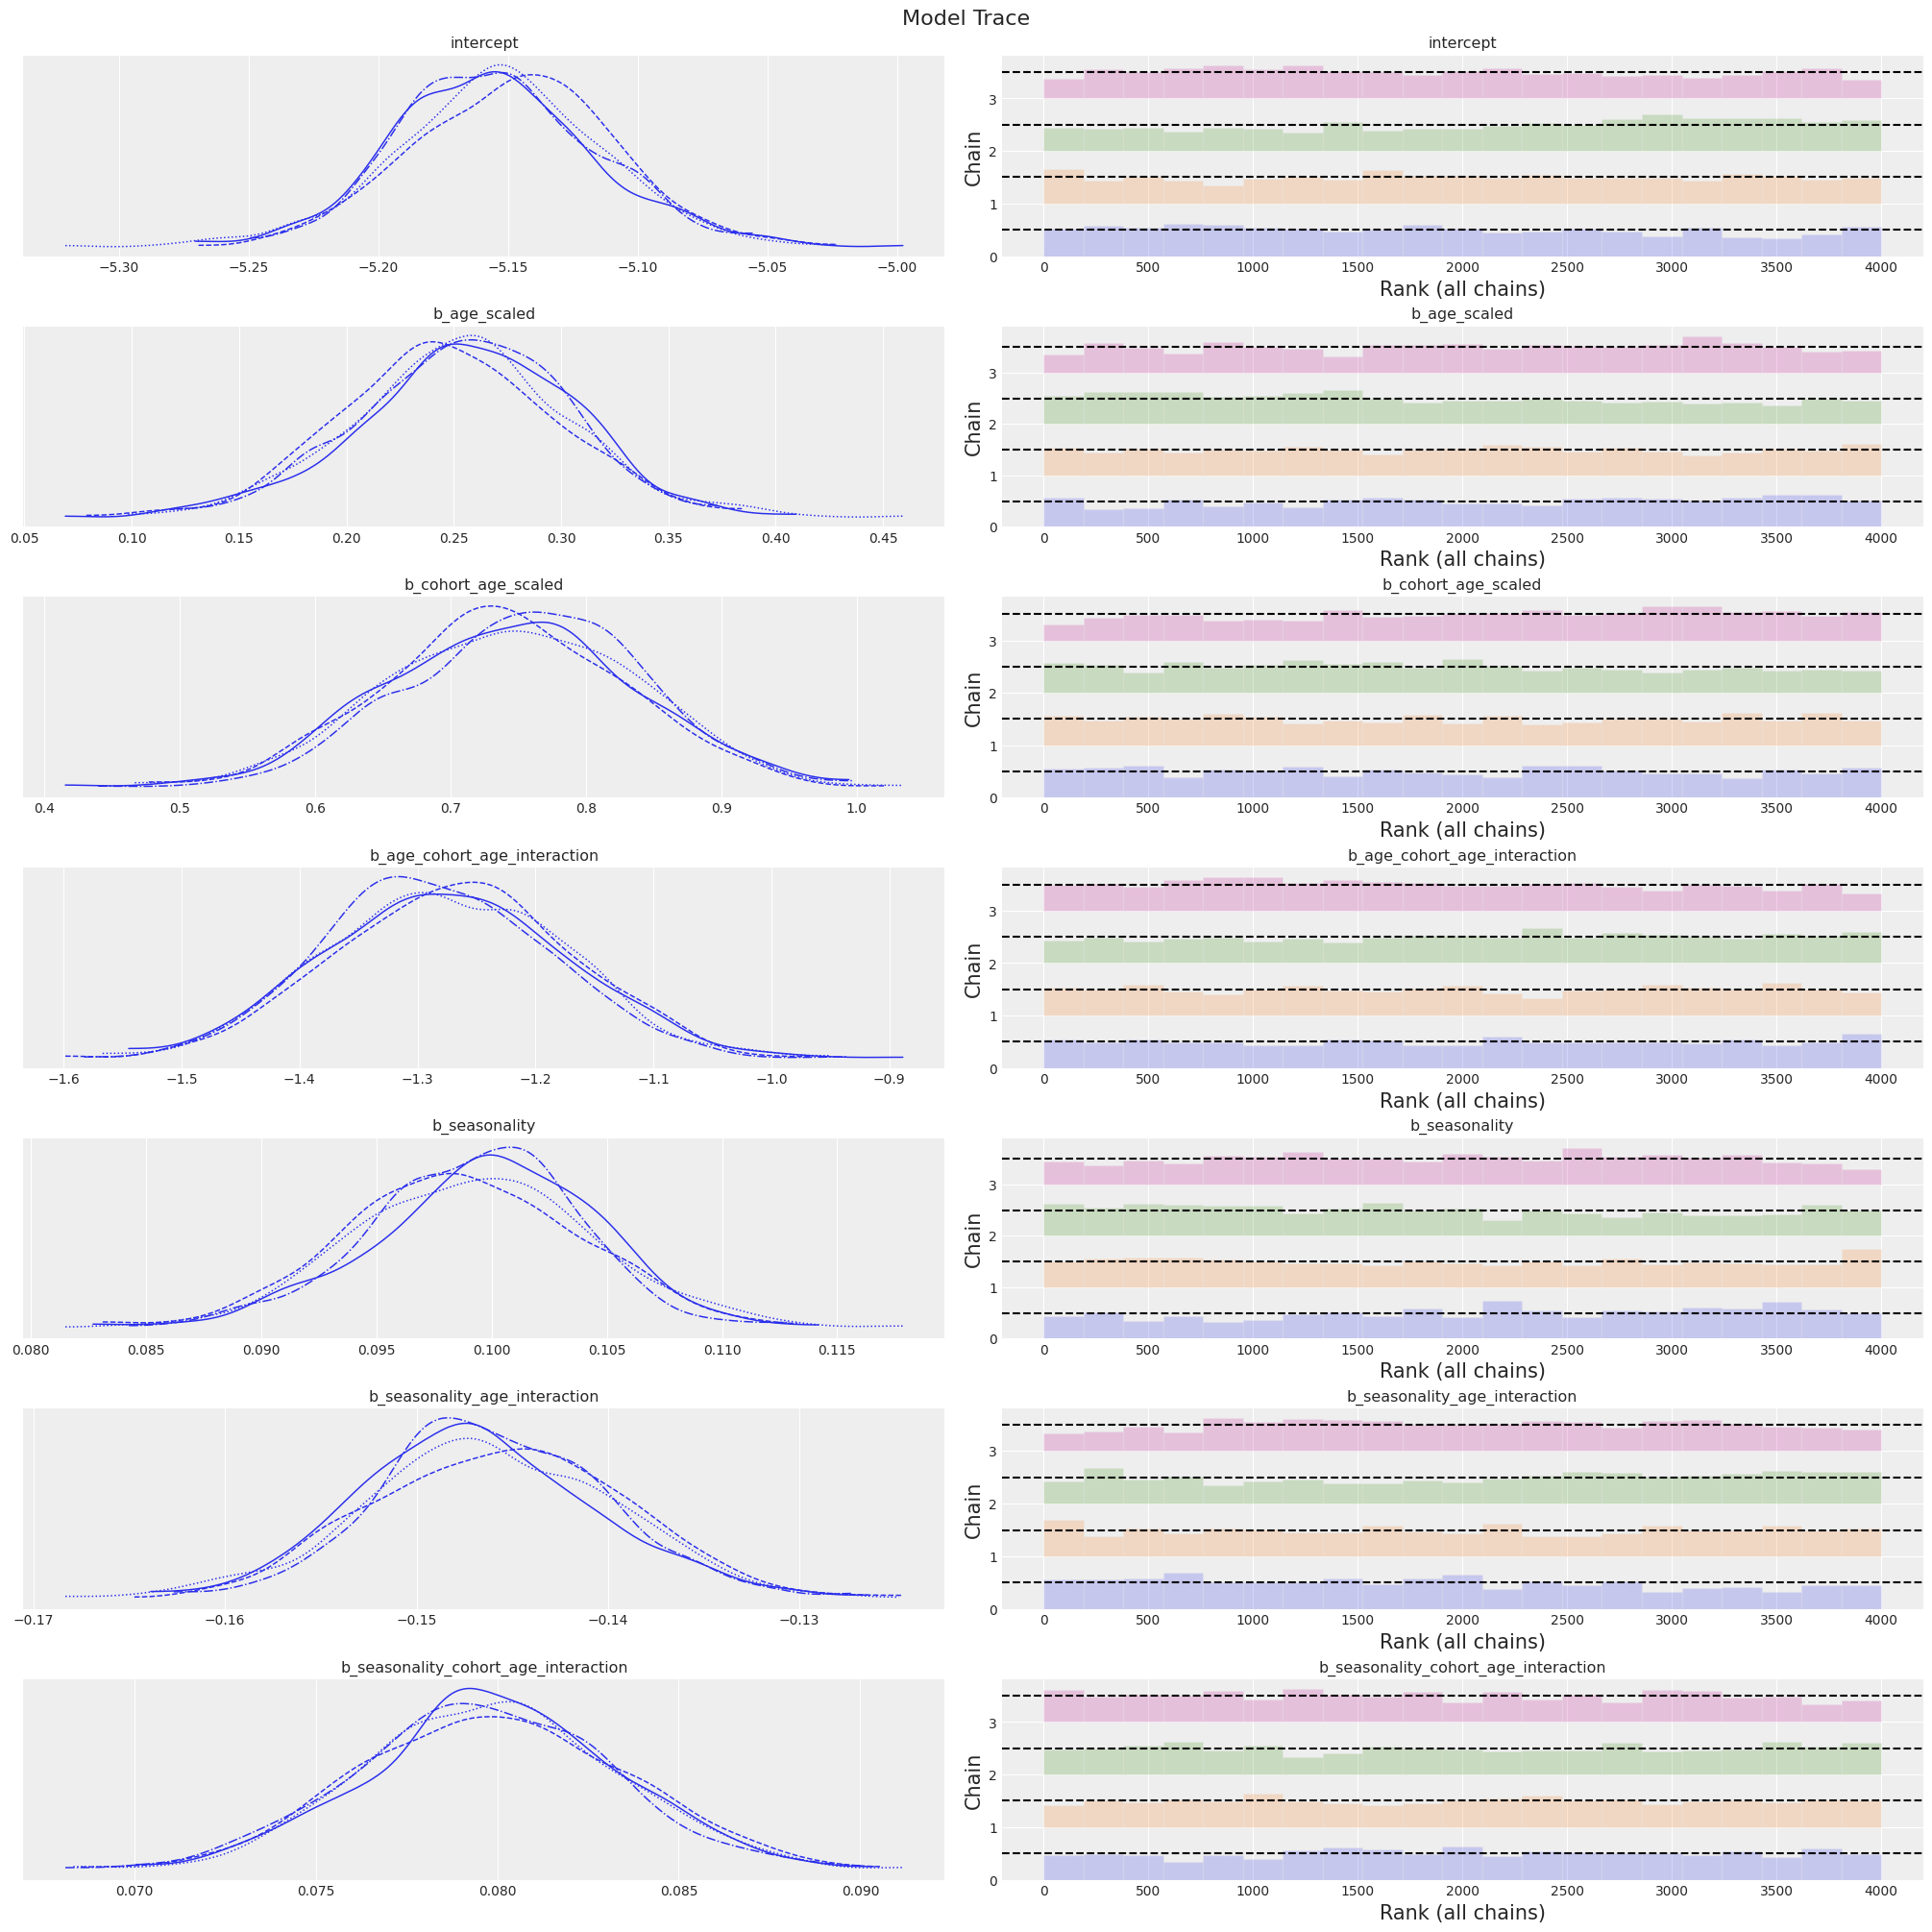

In [20]:
_ = az.plot_trace(
    data=idata,
    var_names=[
        "intercept",
        "b_age_scaled",
        "b_cohort_age_scaled",
        "b_age_cohort_age_interaction",
        "b_seasonality",
        "b_seasonality_age_interaction",
        "b_seasonality_cohort_age_interaction",
    ],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (20, 20), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16)

[Text(0.5, 1.0, 'Posterior Predictive - Revenue Mean'),
 None,
 None,
 Text(0.5, 0, 'revenue (log)'),
 Text(0, 0.5, 'posterior_revenue_mean (log)')]

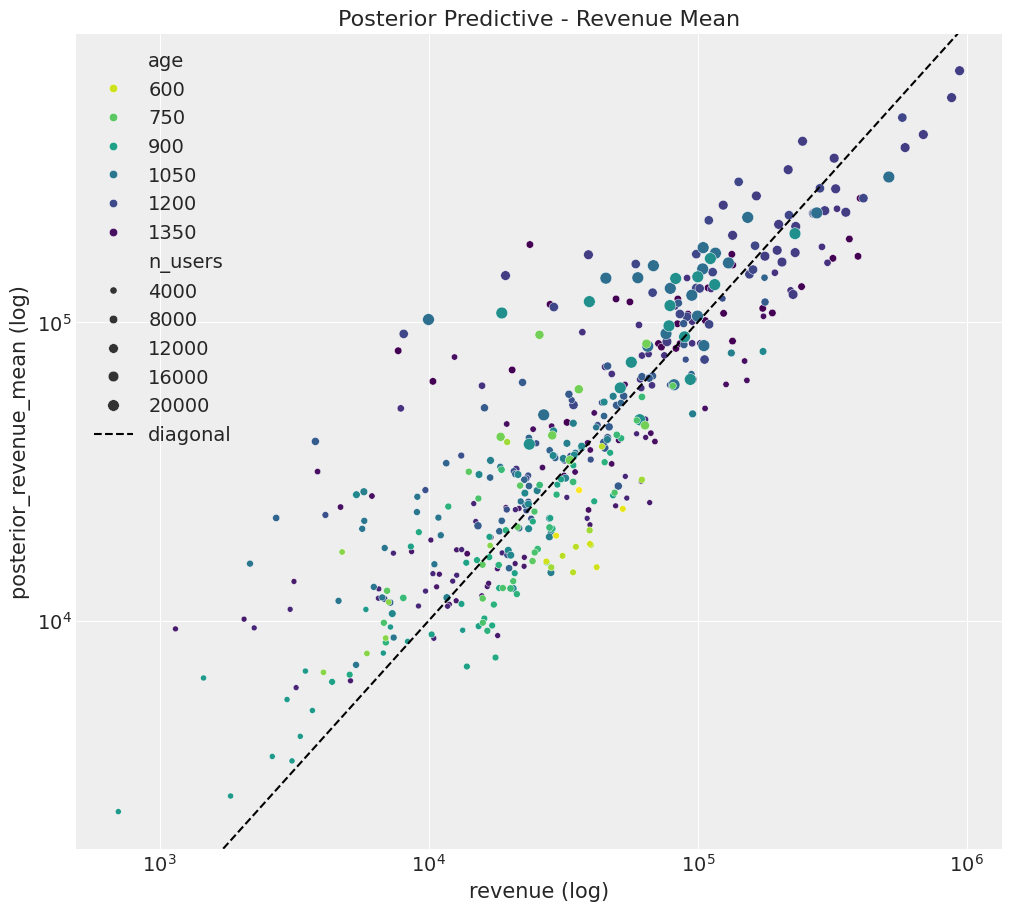

In [21]:
train_posterior_revenue_mean = az.extract(
    data=pos_predictive,
    group="posterior_predictive",
    var_names=["revenue_estimated"],
).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="revenue",
    y="posterior_revenue_mean",
    data=train_features['data_red_df'].assign(posterior_revenue_mean=train_posterior_revenue_mean),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(1e5, 1e5), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(
    title="Posterior Predictive - Revenue Mean",
    xscale="log",
    yscale="log",
    xlabel="revenue (log)",
    ylabel="posterior_revenue_mean (log)",
)

We preprocess our test features.

In [22]:
test_features = deep_ocean_bart.preprocess_train_test_data(
    test_df,
    mode="test",
    seen_cohorts = train_features['cohorts'],
    cohort_encoder = train_features['cohort_encoder'],
    age_scaler = train_features['age_scaler'],
    cohort_age_scaler= train_features['cohort_age_scaler']
)

for key in test_features.keys():
    print(f"{key}: {type(test_features[key])}")

obs_idx: <class 'numpy.ndarray'>
n_users: <class 'numpy.ndarray'>
n_active_users: <class 'numpy.ndarray'>
retention: <class 'numpy.ndarray'>
revenue: <class 'numpy.ndarray'>
features: <class 'list'>
x: <class 'pandas.core.frame.DataFrame'>
period: <class 'numpy.ndarray'>
cohorts: <class 'NoneType'>
cohort_idx: <class 'numpy.ndarray'>
age_scaled: <class 'numpy.ndarray'>
cohort_age_scaled: <class 'numpy.ndarray'>
cohort_encoder: <class 'NoneType'>
age_scaler: <class 'NoneType'>
cohort_age_scaler: <class 'NoneType'>
period_idx: <class 'NoneType'>
retention_logit: <class 'NoneType'>
revenue_per_user: <class 'NoneType'>
data_red_df: <class 'pandas.core.frame.DataFrame'>


We draw new predictions using test features.

In [23]:
model, idata = deep_ocean_bart.draw_new_predictions(model, test_features, idata)

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

We extract our train and teste fit with a helper function.

In [38]:
combined_data, _, _ = deep_ocean_bart.process_idata_posterior_predictive_for_plotting(
    idata = idata,
    posterior_predictive=pos_predictive,
    train_data_red_df=train_features['data_red_df'],
    test_data_red_df=test_features['data_red_df']
)
combined_data['cutoff'] = [cutoff for _ in range(combined_data.shape[0])]
combined_data.reset_index(inplace=True)

In [32]:
forward_revenue = deep_ocean_bart.calculate_forward_revenue(combined_data, months = [3, 6, 12])
evaluations = deep_ocean_bart.evaluate_predictions(combined_data)

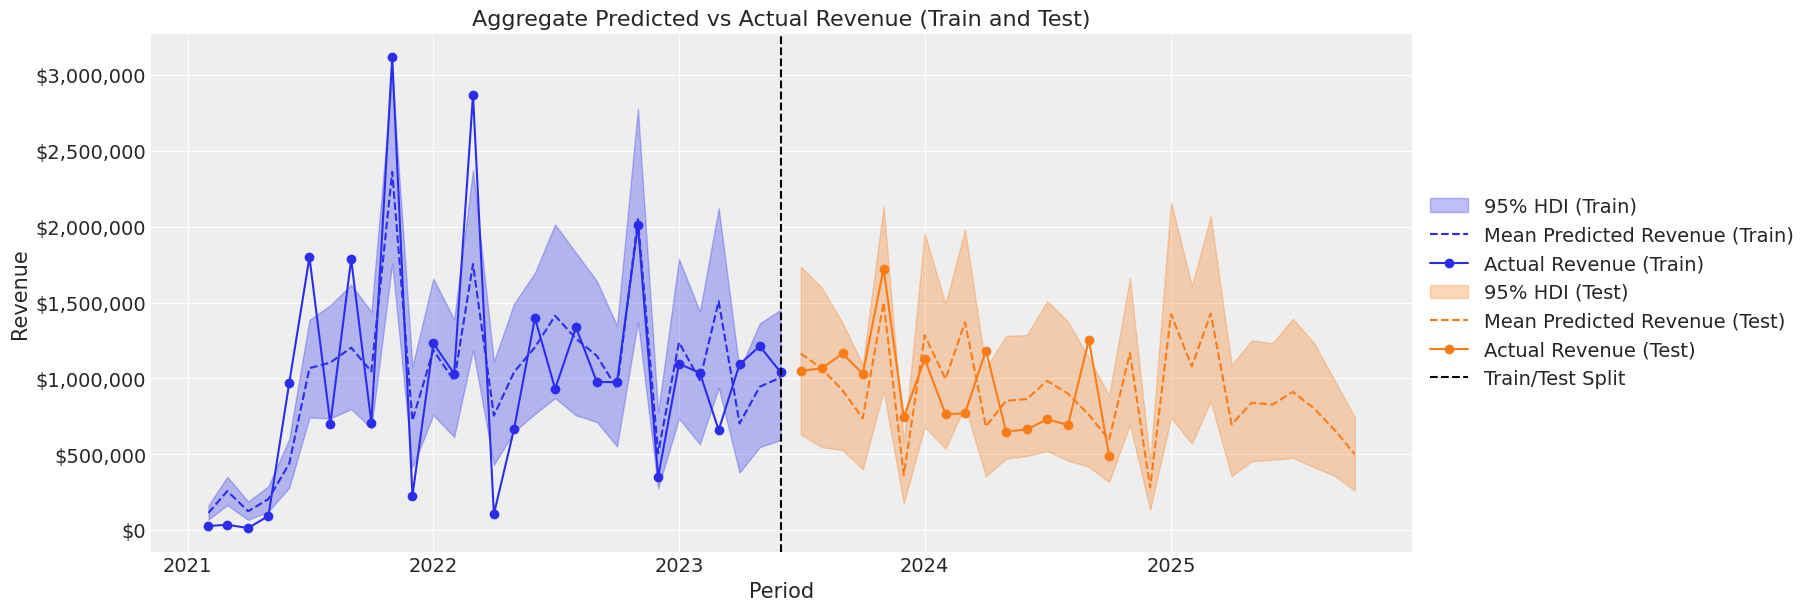

In [39]:
fig, ax = plt.subplots(figsize = (18, 6))
deep_ocean_bart.plot_monthly_revenue(combined_data, ax = ax)

We are interested in the 3, 6, and 12 months forward revenue from the cutoff date.

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_13355/2510412785.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


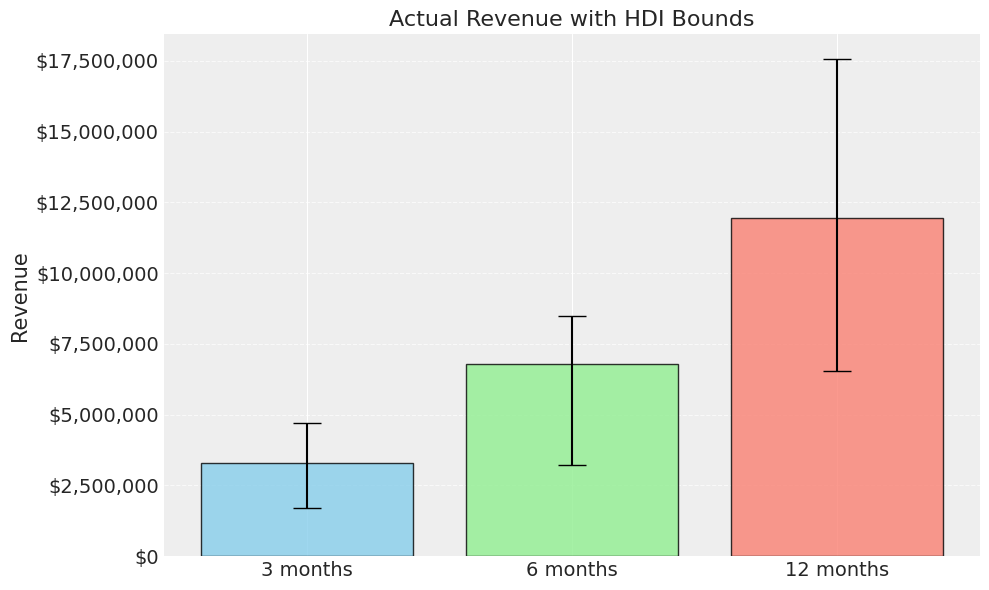

In [77]:
time_horizons = ["3 months", "6 months", "12 months"]
actuals = [forward_revenue[f"{horizon} actual"].values[0] for horizon in time_horizons]
hdi_lowers = [forward_revenue[f"{horizon} HDI Lower"].values[0] for horizon in time_horizons]
hdi_uppers = [forward_revenue[f"{horizon} HDI Upper"].values[0] for horizon in time_horizons]

lower_errors = [actual - lower for actual, lower in zip(actuals, hdi_lowers)]
upper_errors = [upper - actual for actual, upper in zip(actuals, hdi_uppers)]
error = [lower_errors, upper_errors]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(time_horizons))

ax.bar(
    x,
    actuals,
    yerr=error,
    capsize=10,
    color=["skyblue", "lightgreen", "salmon"],
    edgecolor="black",
    alpha=0.8,
)

ax.set_xticks(x, time_horizons)
ax.set_ylabel("Revenue")
ax.set_title("Actual Revenue with HDI Bounds")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()


## Backtesting

We repeat the step above at monthly intervals starting from 2021 June, and examine predicted vs realized forward revenue at each cutoff period.

In [ ]:
date_range = pd.date_range(
    "2021-06-01",
    "2024-10-01",
    freq = "1M"
)


# We log predictions for subsequent plotting
log_file_path = './model_log_0102_2.csv'

log_df = pd.DataFrame(
    columns = [
        'Dataset', 
        'Predicted Revenue', 
        'Actual Revenue', 
        'hdi_lower',
        'hdi_upper', 
        'cutoff'
    ]
)
log_df.to_csv(log_file_path)

transactions = deep_ocean_bart.load_transactions('./transactions.csv')
transactions = deep_ocean_bart.preprocess_transactions(transactions)
cohort = deep_ocean_bart.preprocess_transactions_to_cohort(transactions)

# For this attempt, we use fitted posteriors as priors for the subsequent cutoff date
latest_posteriors = {}

for i, cutoff in enumerate(date_range):
    cutoff = datetime.datetime.strftime(cutoff, format = "%Y-%m-%d")
    print(f"Processing {cutoff}")
    train_df, test_df = deep_ocean_bart.custom_train_test_split(cutoff, cohort)
    train_features = deep_ocean_bart.preprocess_train_test_data(train_df, mode = "train")

    if i == 0:
        model = deep_ocean_bart.build_new_model(train_features, use_default_priors=True)
    else:
        model = deep_ocean_bart.build_new_model(
            train_features, 
            use_default_priors=True,
            informative_priors= latest_posteriors
        )
    model, idata, pos_predictive = deep_ocean_bart.fit_model(model)

    latest_posteriors = deep_ocean_bart.extract_posteriors(idata)

    test_features = deep_ocean_bart.preprocess_train_test_data(
        test_df,
        mode="test",
        seen_cohorts = train_features['cohorts'],
        cohort_encoder = train_features['cohort_encoder'],
        age_scaler = train_features['age_scaler'],
        cohort_age_scaler= train_features['cohort_age_scaler']
    )
    model, idata = deep_ocean_bart.draw_new_predictions(model, test_features, idata)

    combined_data = deep_ocean_bart.process_idata_posterior_predictive_for_plotting(
        idata = idata,
        posterior_predictive=pos_predictive,
        train_data_red_df=train_features['data_red_df'],
        test_data_red_df=test_features['data_red_df']
    )
    combined_data['cutoff'] = [cutoff for _ in range(combined_data.shape[0])]
    combined_data.reset_index(inplace=True)

    log_df = pd.read_csv(log_file_path, index_col=0)
    log_df = pd.concat([log_df, combined_data], ignore_index=True)
    log_df.to_csv(log_file_path)


In [78]:
log_df = pd.read_csv('./model_log_0102_2.csv', index_col = 0)
log_df['period'] = pd.to_datetime(log_df['period'], format = "mixed")
log_df['cutoff'] = pd.to_datetime(log_df['cutoff'], format = "mixed")

forward_revenue = deep_ocean_bart.calculate_forward_revenue(log_df, months = [3, 6, 12])
evaluations = deep_ocean_bart.evaluate_predictions(log_df)


Predictions prior to 2022 are extremely off, we filter out the first 2 months and start plotting from 2021-Sept onwards.

/Users/fanghema/Desktop/Deep Ocean - BART/deep_ocean_bart.py:1309: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


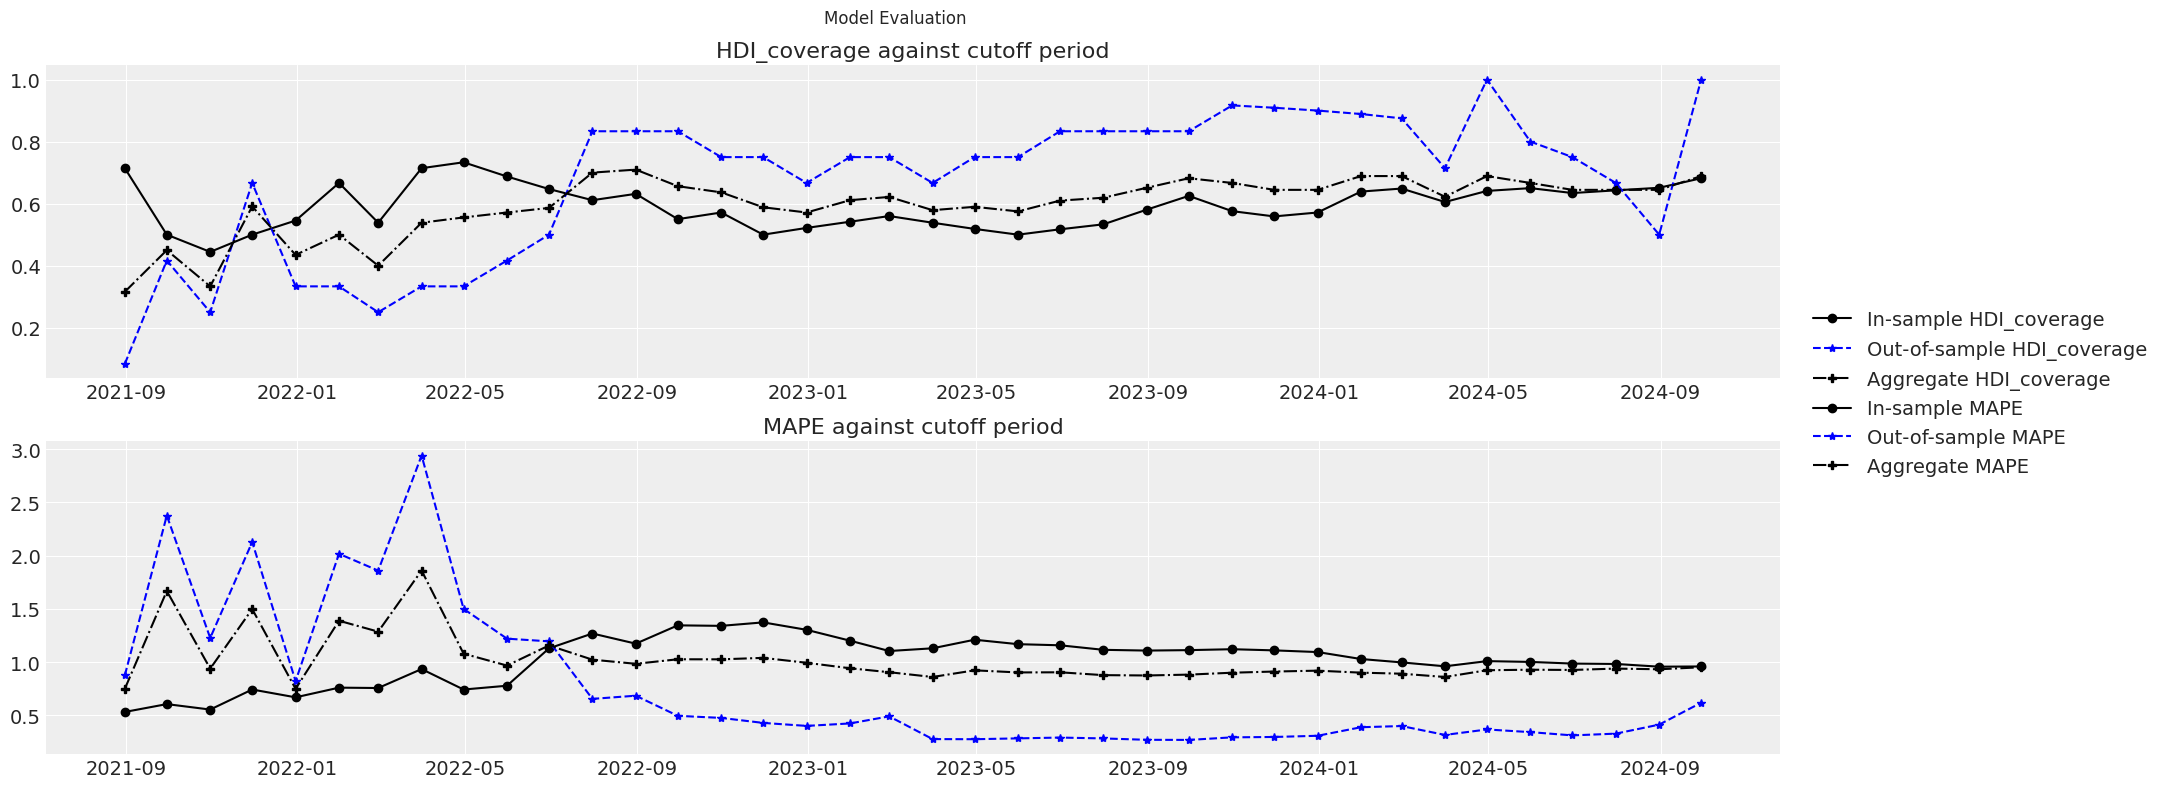

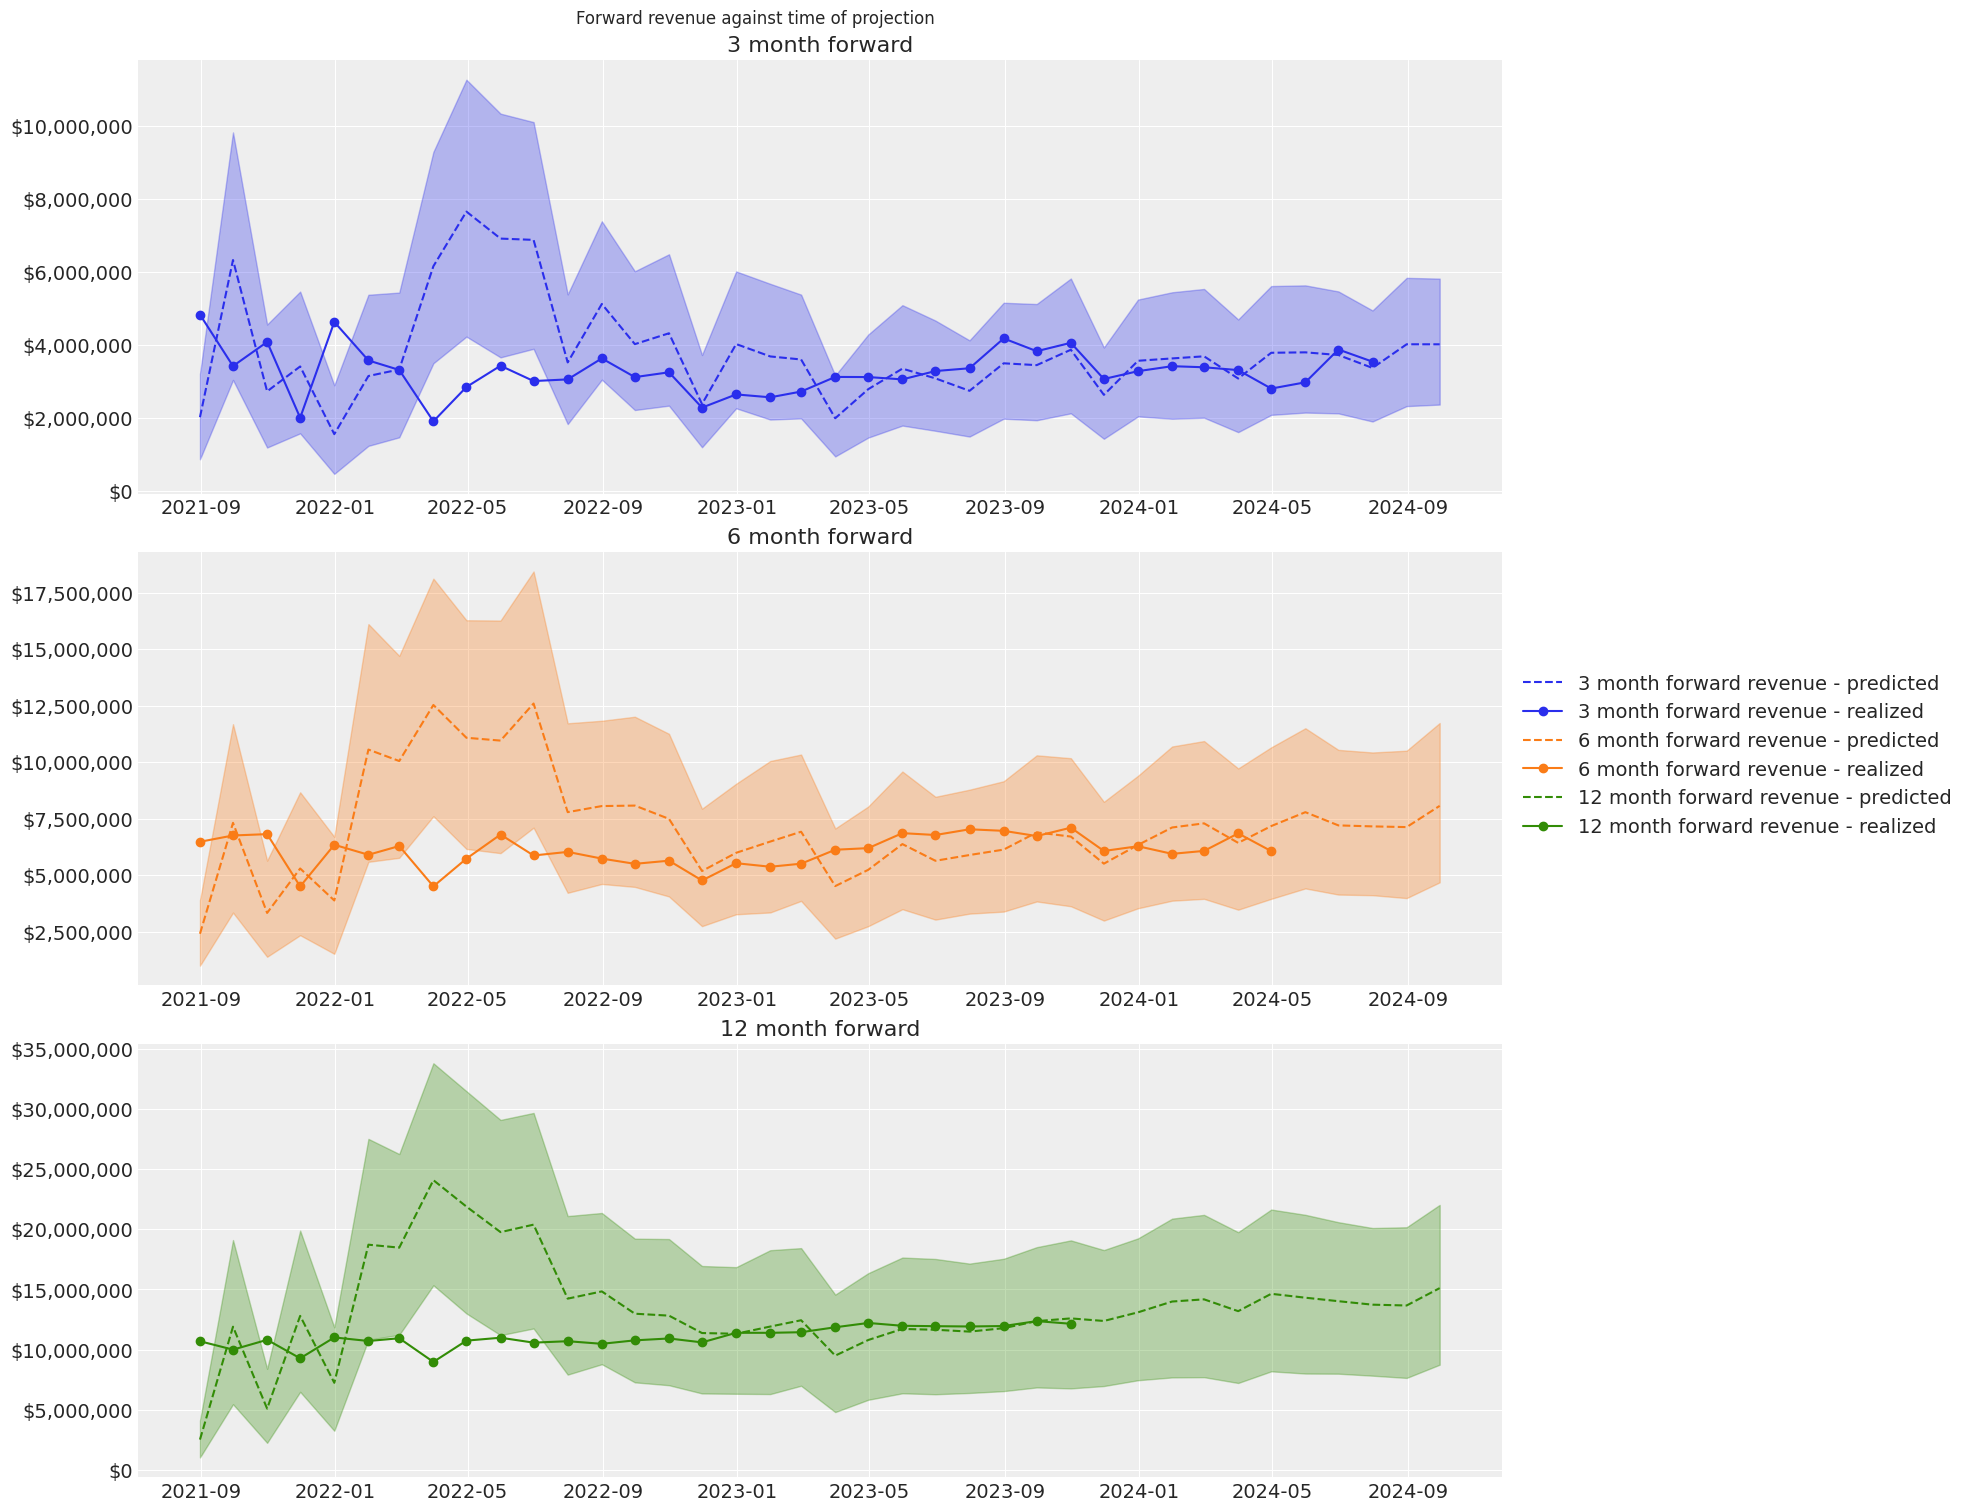

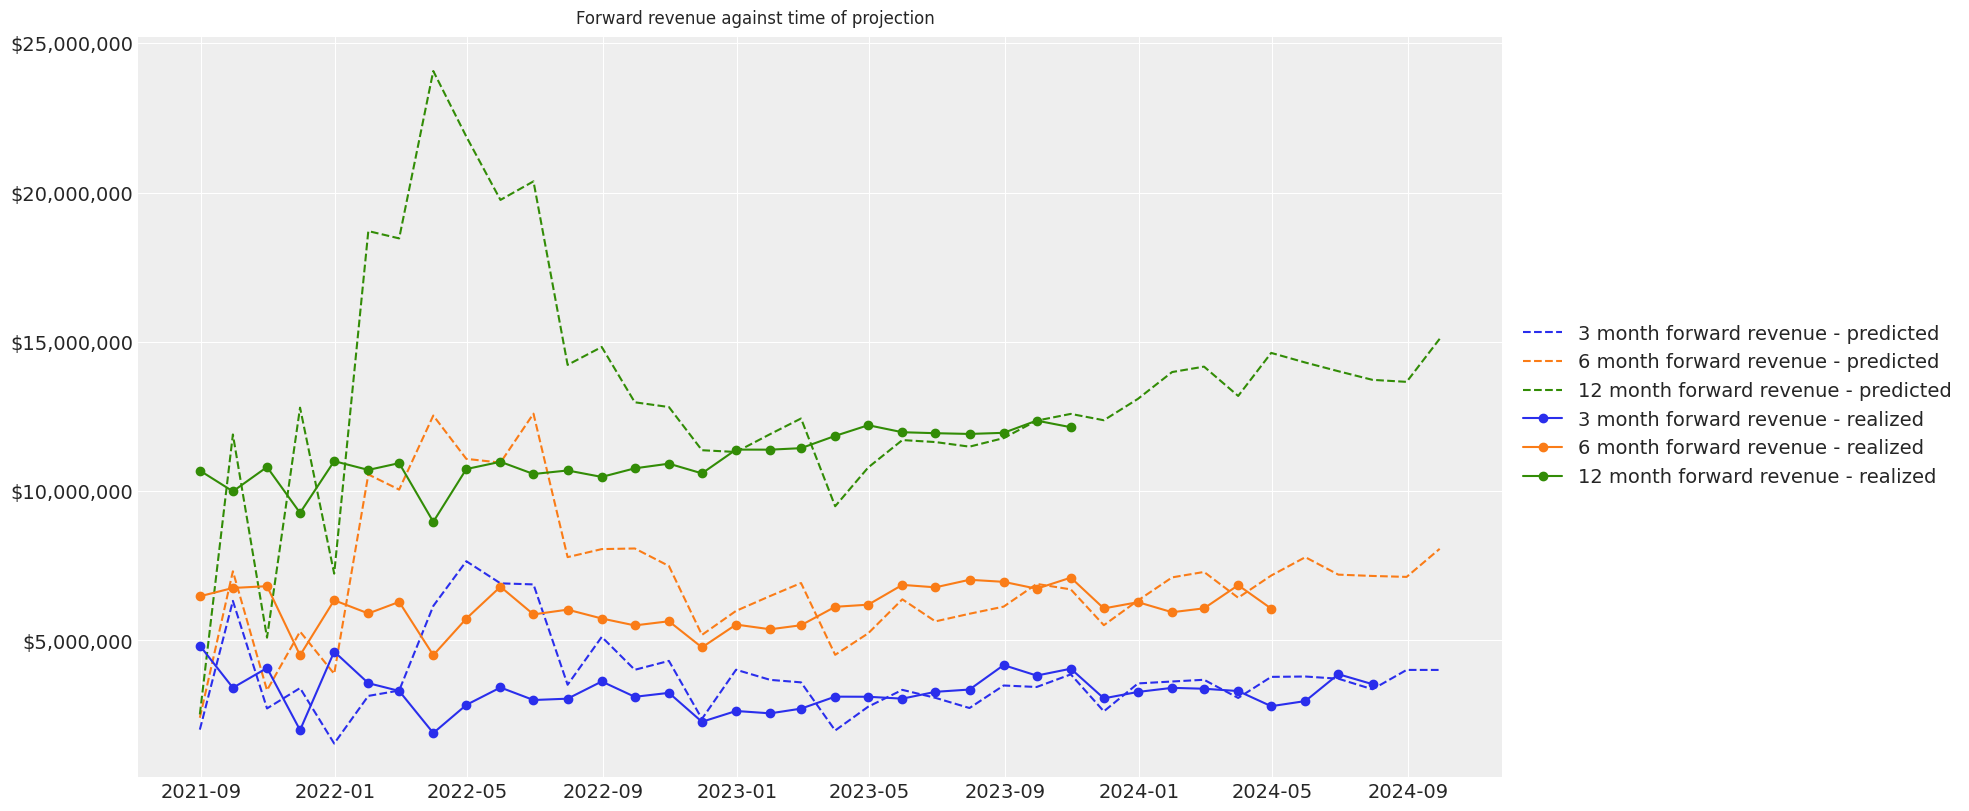

In [79]:
deep_ocean_bart.plot_evaluations(evaluations=evaluations.iloc[2:, :])
deep_ocean_bart.plot_forward_revenue(forward_revenue=forward_revenue.iloc[2:, :], show_CI=True)
deep_ocean_bart.plot_forward_revenue(forward_revenue=forward_revenue.iloc[2:, :], show_CI=False)